<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/0317_%EC%BA%90%EA%B8%80_%ED%95%84%EC%82%AC_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None # defalut = 'warn'

%matplotlib inline : 주피터 노트북에서 그래프를 코드 셀 아래에 바로 보여 주는 매직 명령어
pd.options.mode.chained_assignment : chained assignment 일 때, 즉 원본 데이터 프레임이 바뀔 수도 있는 할당을 할 때 띄워 주는 경고 관리 옵션
 - warn: defalut, 경고 띄워 줌
 - raise: 아예 에러 발생
 - None: 아무 경고도 안 띄움

In [19]:
from subprocess import check_output
print(check_output(["ls", "../content"]).decode("utf8"))

aisles.csv
departments.csv
drive
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_data
sample_submission (1).csv
sample_submission.csv



import os
print(os.getcwd())
> 작업 중인 경로 확인 코드

In [20]:
order_products_train_df = pd.read_csv("/content/order_products__train.csv")
order_products_prior_df = pd.read_csv("/content/order_products__prior.csv")
orders_df = pd.read_csv("/content/orders.csv")
products_df = pd.read_csv("/content/products.csv")
aisles_df = pd.read_csv("/content/aisles.csv")
departments_df = pd.read_csv("/content/departments.csv")

In [21]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


order_id : 주문 고유 번호

user_id	: 사용자 고유 번호

eval_set	:	데이터셋 구분 (prior/train/test)

order_number	:	사용자의 주문 순서 (1부터 시작)

order_dow	:	주문한 요일 (0=일요일 ~ 6=토요일)

order_hour_of_day	:	주문한 시간 (0시 ~ 23시)

days_since_prior_order	:	이전 주문과의 간격 (일 단위)

In [22]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0


In [23]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


order_id	:	주문 ID (orders.csv와 연결할 수 있는 키)

product_id	:	상품 ID (products.csv와 연결할 수 있는 키)

add_to_cart_order	:	이 상품이 장바구니에 몇 번째로 추가되었는지 (장바구니 순서)

reordered	:	재주문 여부
- 1: 과거에 주문한 적 있는 상품을 재주문
- 0: 처음 주문한 상품

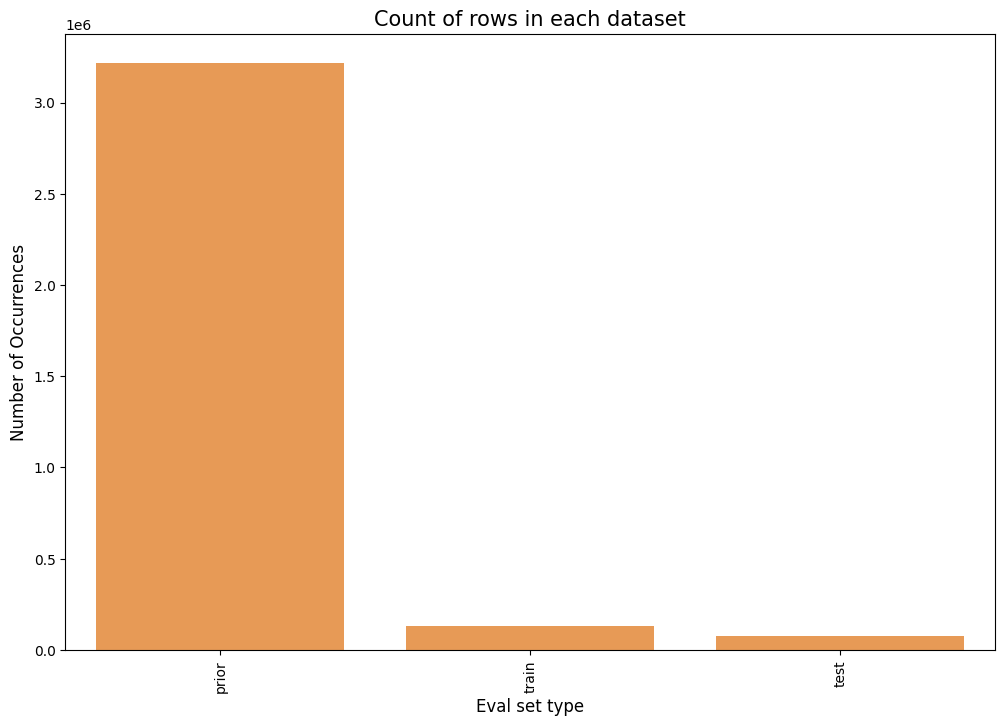

In [24]:
cnt_srs = orders_df.eval_set.value_counts()
#df.칼럼명 < 이런 식으로 칼럼을 선택할 수도 있음

plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8, color=color[1])

#cnt_srs.index > X축 값 (카테고리), eval_set의 값들이 들어가 있음 (['prior', 'train', 'test'] 같은 값)
#cnt_srs.values > Y축 값 (카테고리별 개수), 각 eval_set 값에 대한 카운트 수 (숫자들)
#X축은 prior, train, test / Y축은 각각의 개수 (예를 들면 32434489, 1312097, 75000)
#alpha > 0과 1 사이 값으로 투명도 조절

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [25]:
def get_unique_count(x):
  return len(np.unique(x))

# np.unique(x): 배열 x 안에서 중복을 제거하고 고유값만 남긴 배열을 반환
# len(): 배열의 길이, 여기선 고유값의 개수를 리턴

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
# user_id를 각각 eval_set별로 그룹화하고, 그룹 안에 user가 몇 명이 있는지 수를 세는 코드
# .aggregate(get_unique_count) : user_id 데이터에 대해 get_unique_count() 함수를 적용하여 반환
# cnt_srs = orders_df.groupby("eval_set")["user_id"].nunique() 를 써도 같은 결과 출력
# npunique() > 넘파이 함수로, 고유값을 배열로 반환
# nunique() > 고유값의 '개수'만 반환
# .aggregate()를 쓰면 다양한 사용자 정의 함수를 인자로 사용할 수 있다는 장점이 있음


cnt_srs

,user_id
eval_set,
prior,206209
test,75000
train,131209


<ipython-input-26-9593f0849f99>:1: FutureWarning: The provided callable <function max at 0x7e40503989a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()


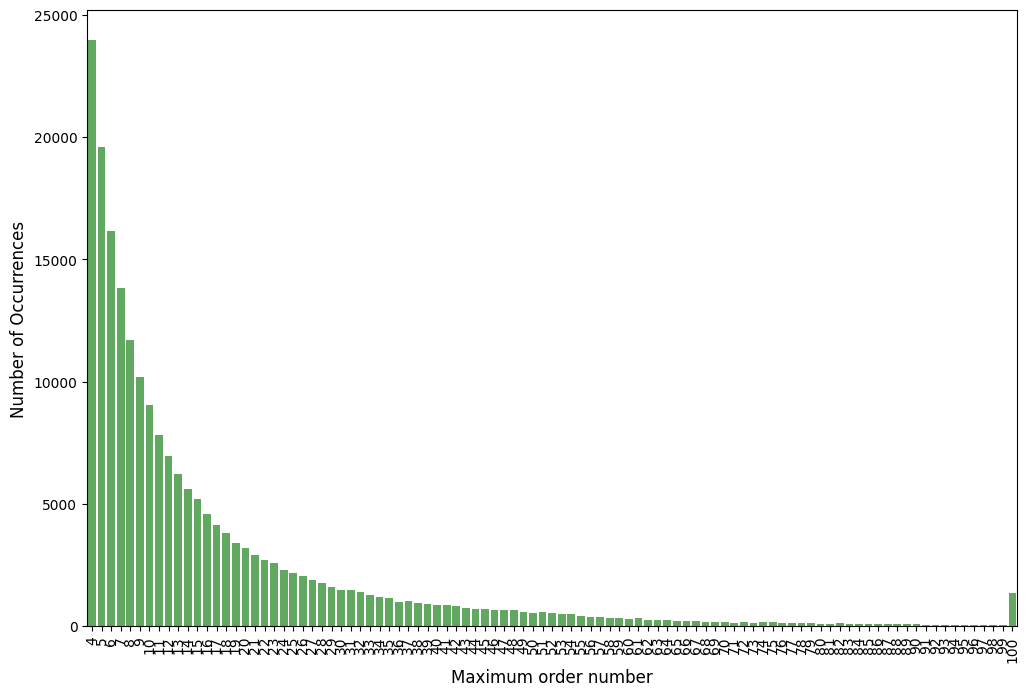

In [26]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
# 각 사용자별로 그룹화하여 order_number 컬럼에서 최댓값을 구함 > 최댓값이 총 주문 횟수니까
#reset_index를 씀으로써 user_id가 인덱스가 아닌 일반 컬럼으로 인식되도록 해서 시각화 편하도록
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

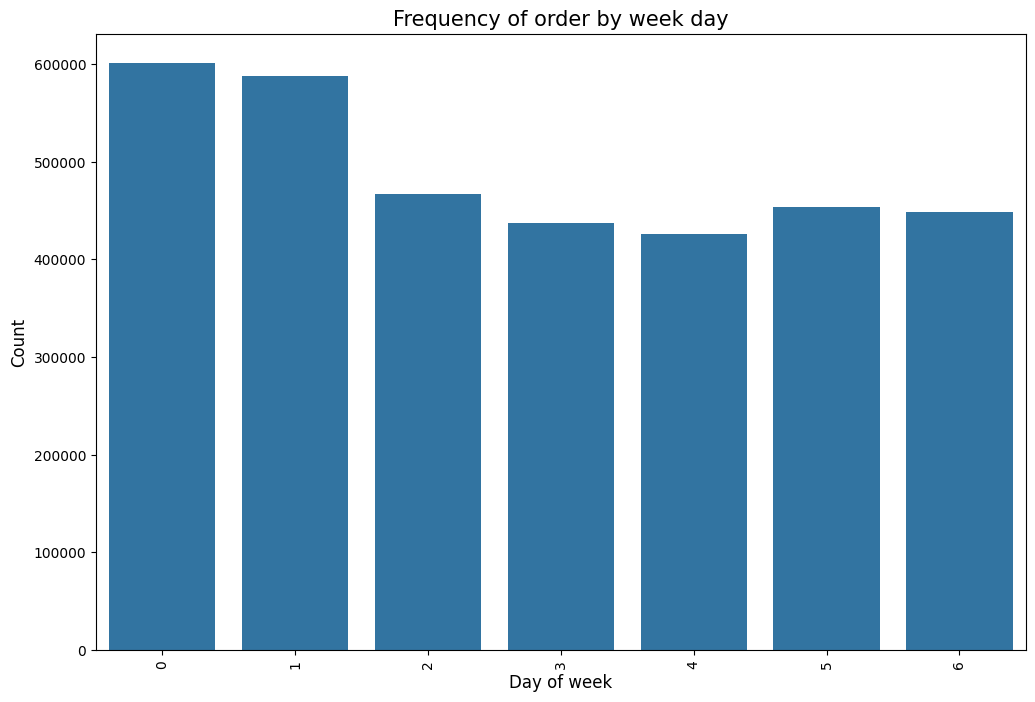

In [27]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

일요일[0]과 월요일[1]에 가장 주문이 많음

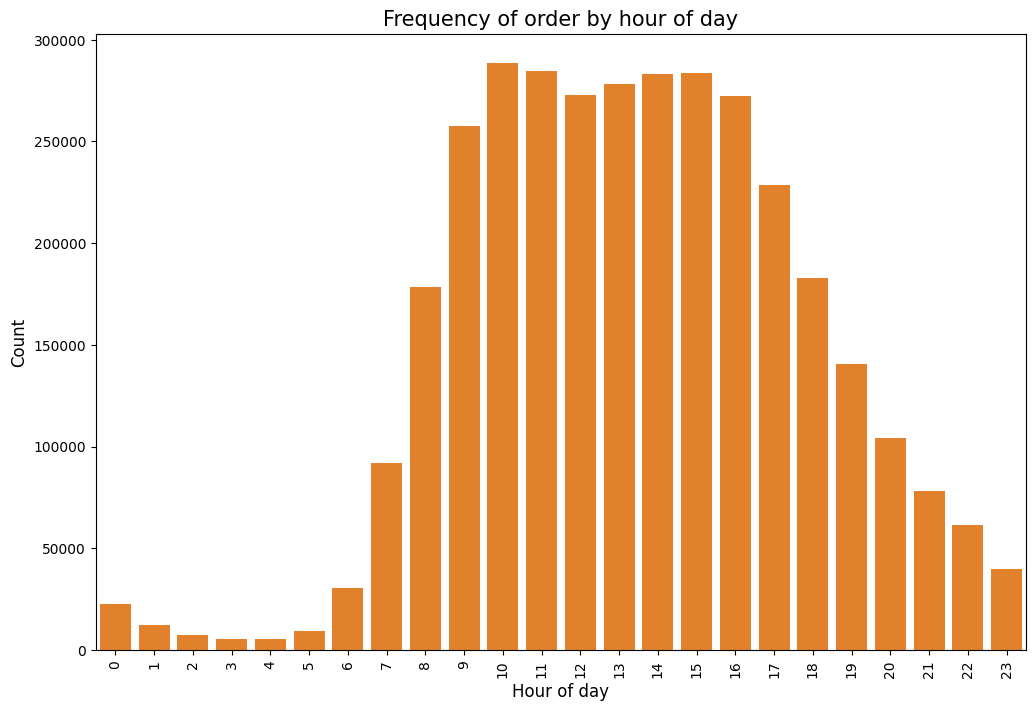

In [28]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

9-18 사이에 주문이 가장 많음

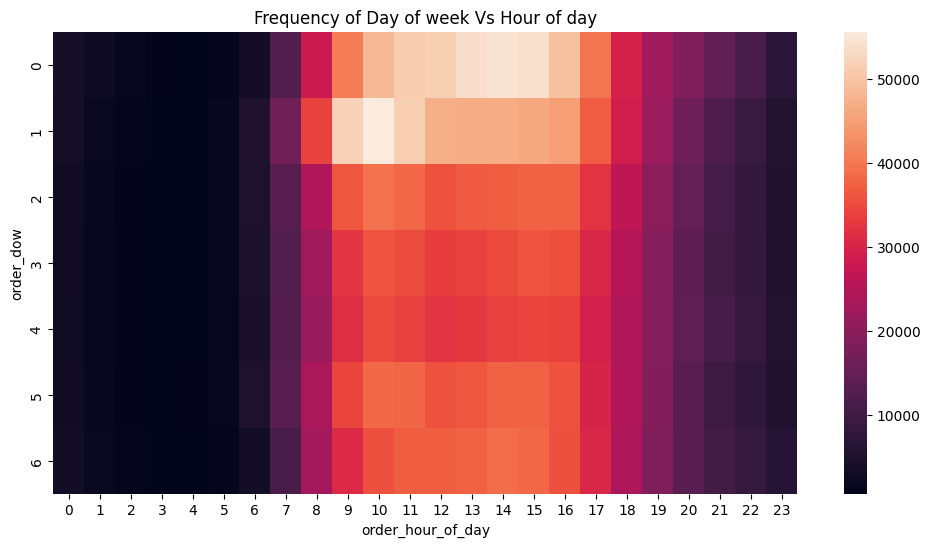

In [29]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
#요일과 시간대 별로 그룹화한 뒤, order_number로 카운트 연산해서 해당 요일과 시간대에 주문이 몇 개였는지
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

pivot(index=..., columns=..., values=...)처럼 인자를 써 줘야 함

어떤 요일의 어떤 시간에 주문이 몰리는지 상관히트맵으로 시각화

1. 첨부된 링크의 캐글 노트북의 모든 코드를 빠짐없이 필사
- 새롭게 공부한 내용(개념, 코드)을 함께 정리해두기를 추천합니다.
1. ❗새로운 전처리/시각화를 1가지 이상 적용❗하고 분석 결과 설명

> 바이올린 플롯으로 요일별 시간대에 따른 주문량을 더 직관적으로 시각화

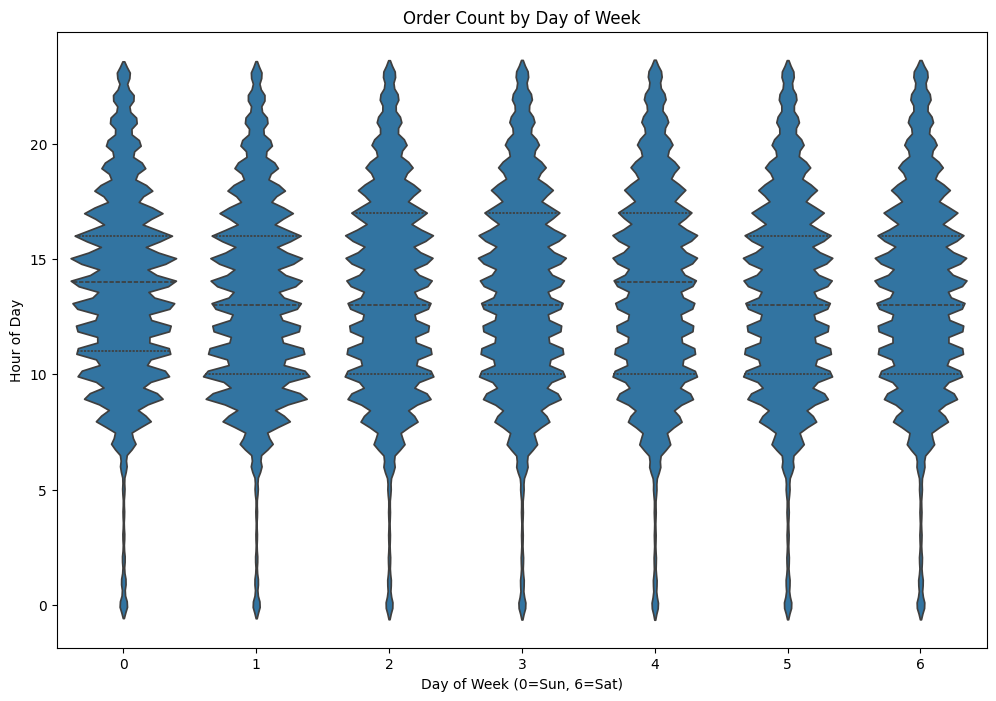

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.violinplot(x = 'order_dow', y='order_hour_of_day', data=orders_df, inner='quartile')
# inner 인자를 사용하여 사분위수를 더 뚜렷하게 나타냄
plt.title('Order Count by Day of Week')
plt.xlabel('Day of Week (0=Sun, 6=Sat)')
plt.ylabel('Hour of Day')
plt.show()

그래프 결과 분석: 요일과 관계 없이 대부분의 주문이 9~18시 사이에 집중되어 있다.

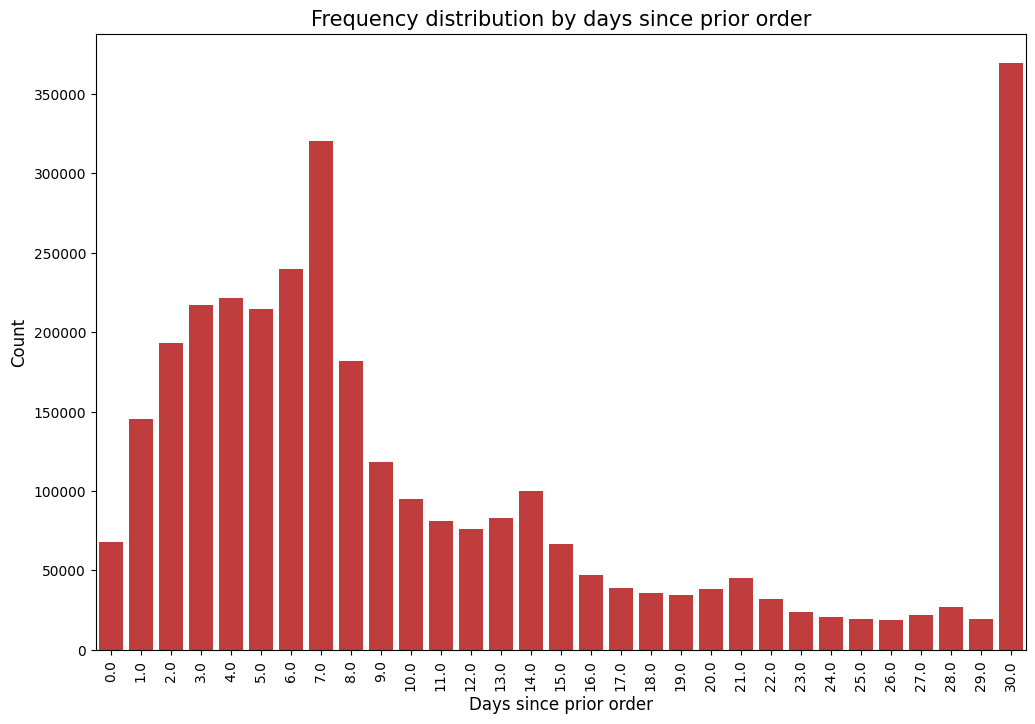

In [30]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

In [31]:
# percentage of re-orders in prior set #
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

np.float64(0.5892298815046485)

In [32]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

np.float64(0.5985944127509629)

In [33]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

AttributeError: 'Series' object has no attribute 'ix'

.ix는 loc와 iloc의 역할을 동시에 하는 메서드였으나 지금은 사라졌으므로, 여기서는 라벨 기반 인덱싱인 loc를 사용하여 오류를 해결

In [34]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df.loc[grouped_df["reordered"] > 1, "reordered"] = 1
#1보다 크면 재주문이므로, 재주문이냐 아니냐 0과 1 이진수로 나타내기 위해 1로 변경
grouped_df.reordered.value_counts() / grouped_df.shape[0]

,count
reordered,
1.0,0.878868
0.0,0.121132


In [36]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df.loc[grouped_df["reordered"] > 1, "reordered"] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

,count
reordered,
1,0.93444
0,0.06556


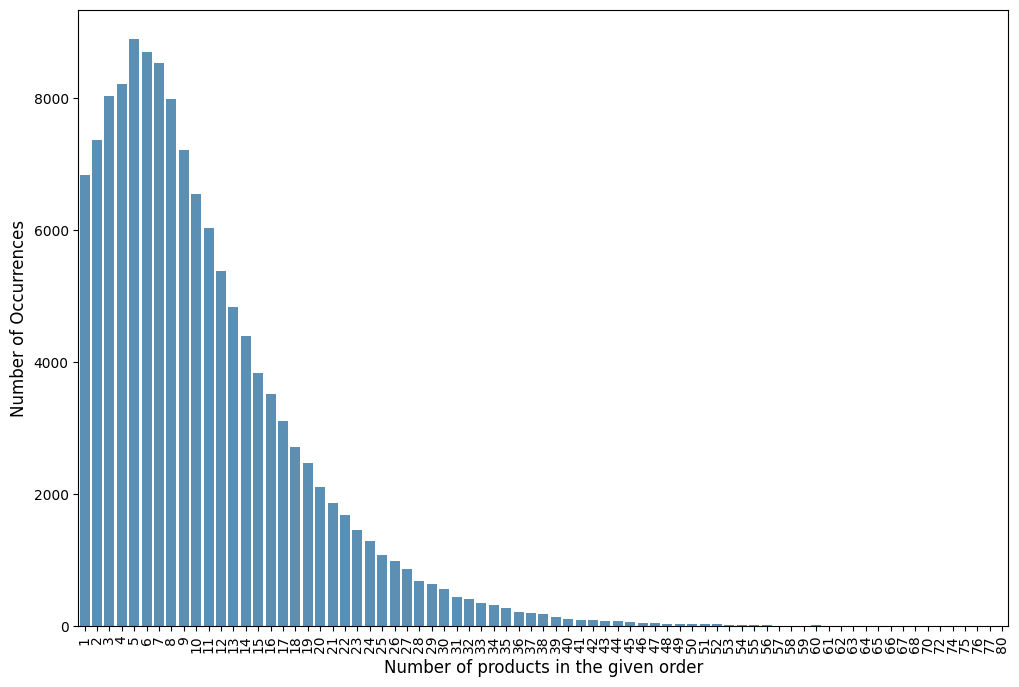

In [37]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [38]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [39]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [40]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [41]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

# pd.merge : 두 개의 데이터프레임을 병합하기 위한 함수
# 두 데이터프레임에 공통 키가 있을 때 쓰거나 정보가 나뉘어 있는 데이터를 하나로 합칠 때
# on : "병합 기준이 되는 컬럼 이름"
# suffixes : 겹치는 컬럼 이름 처리할 때 접미사를 붙여서 다르게 만들어 줌

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120.0,1.0,1.0,Organic Egg Whites,86.0,16.0,eggs,dairy eggs
1,2,28985.0,2.0,1.0,Michigan Organic Kale,83.0,4.0,fresh vegetables,produce
2,2,9327.0,3.0,0.0,Garlic Powder,104.0,13.0,spices seasonings,pantry
3,2,45918.0,4.0,1.0,Coconut Butter,19.0,13.0,oils vinegars,pantry
4,2,30035.0,5.0,0.0,Natural Sweetener,17.0,13.0,baking ingredients,pantry


In [42]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,111894
1,Bag of Organic Bananas,89409
2,Organic Strawberries,62730
3,Organic Baby Spinach,56825
4,Organic Hass Avocado,50366
5,Organic Avocado,41385
6,Large Lemon,35901
7,Strawberries,33691
8,Limes,33088
9,Organic Whole Milk,32428


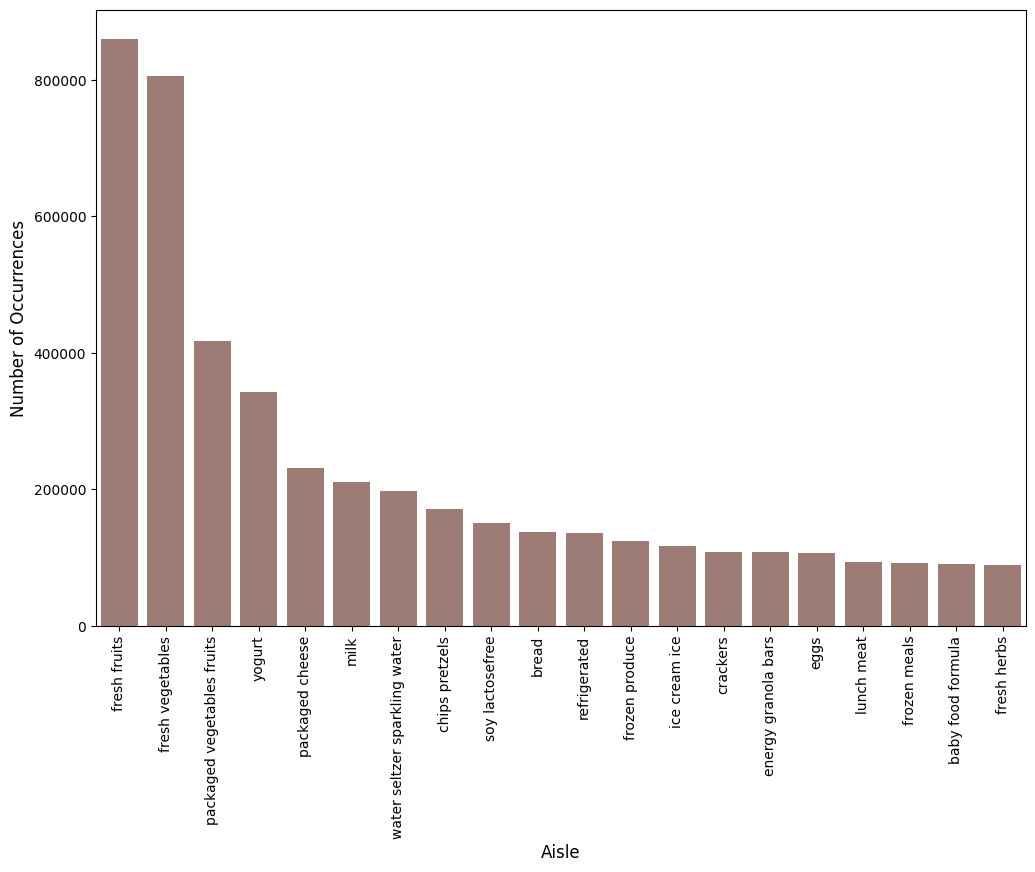

In [43]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

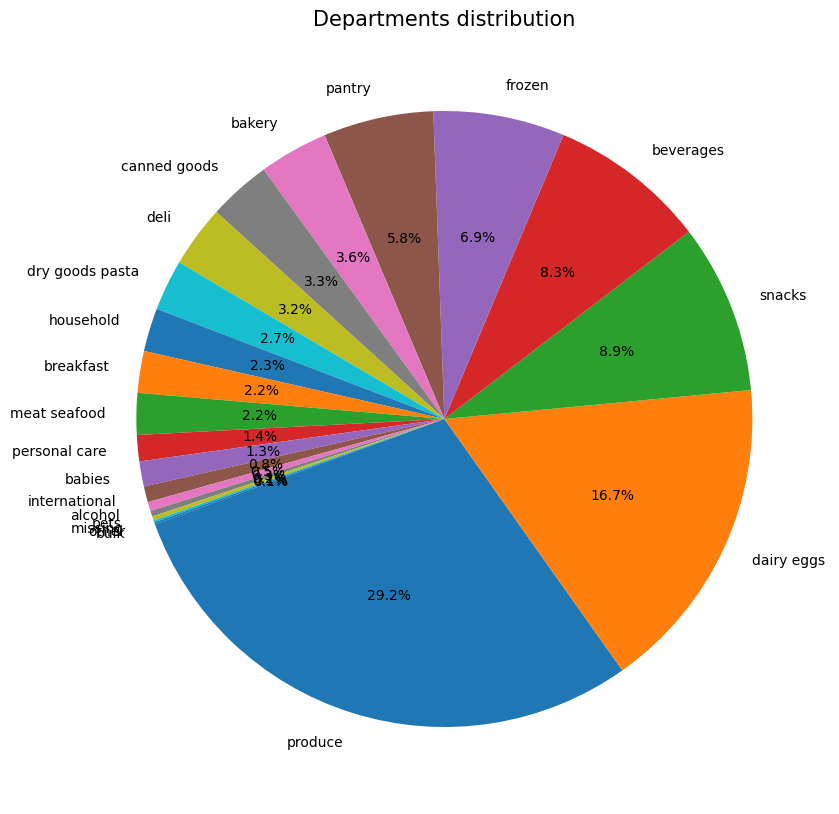

In [44]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels,
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

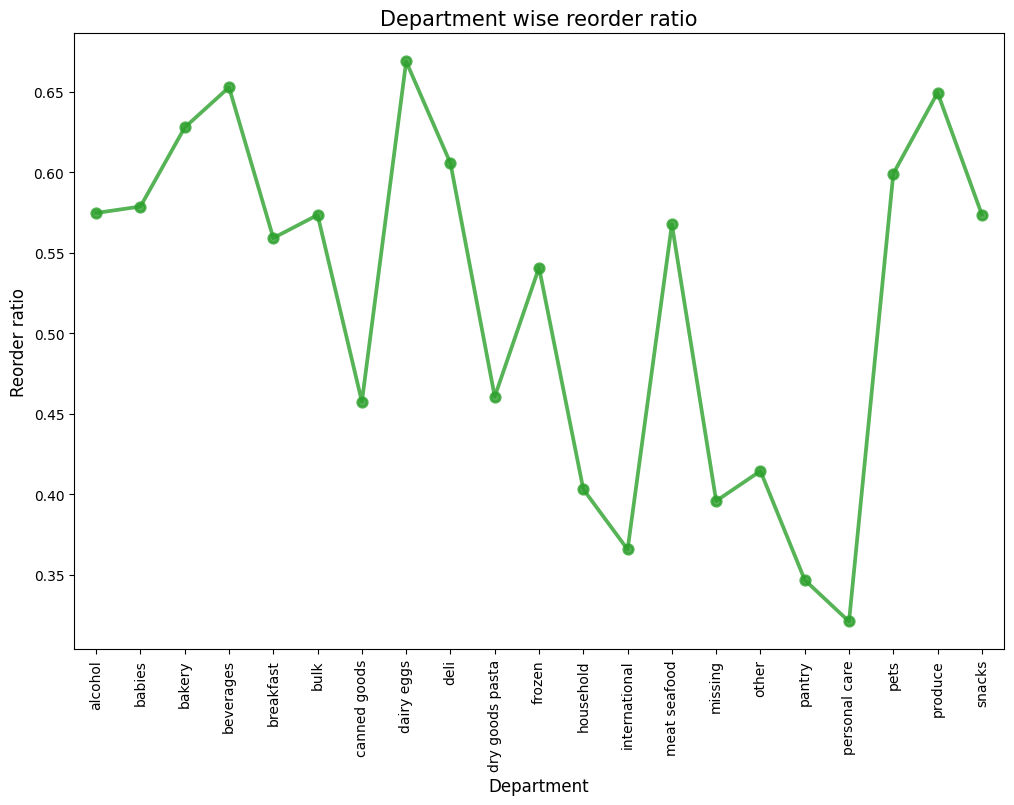

In [45]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x = grouped_df['department'].values, y = grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

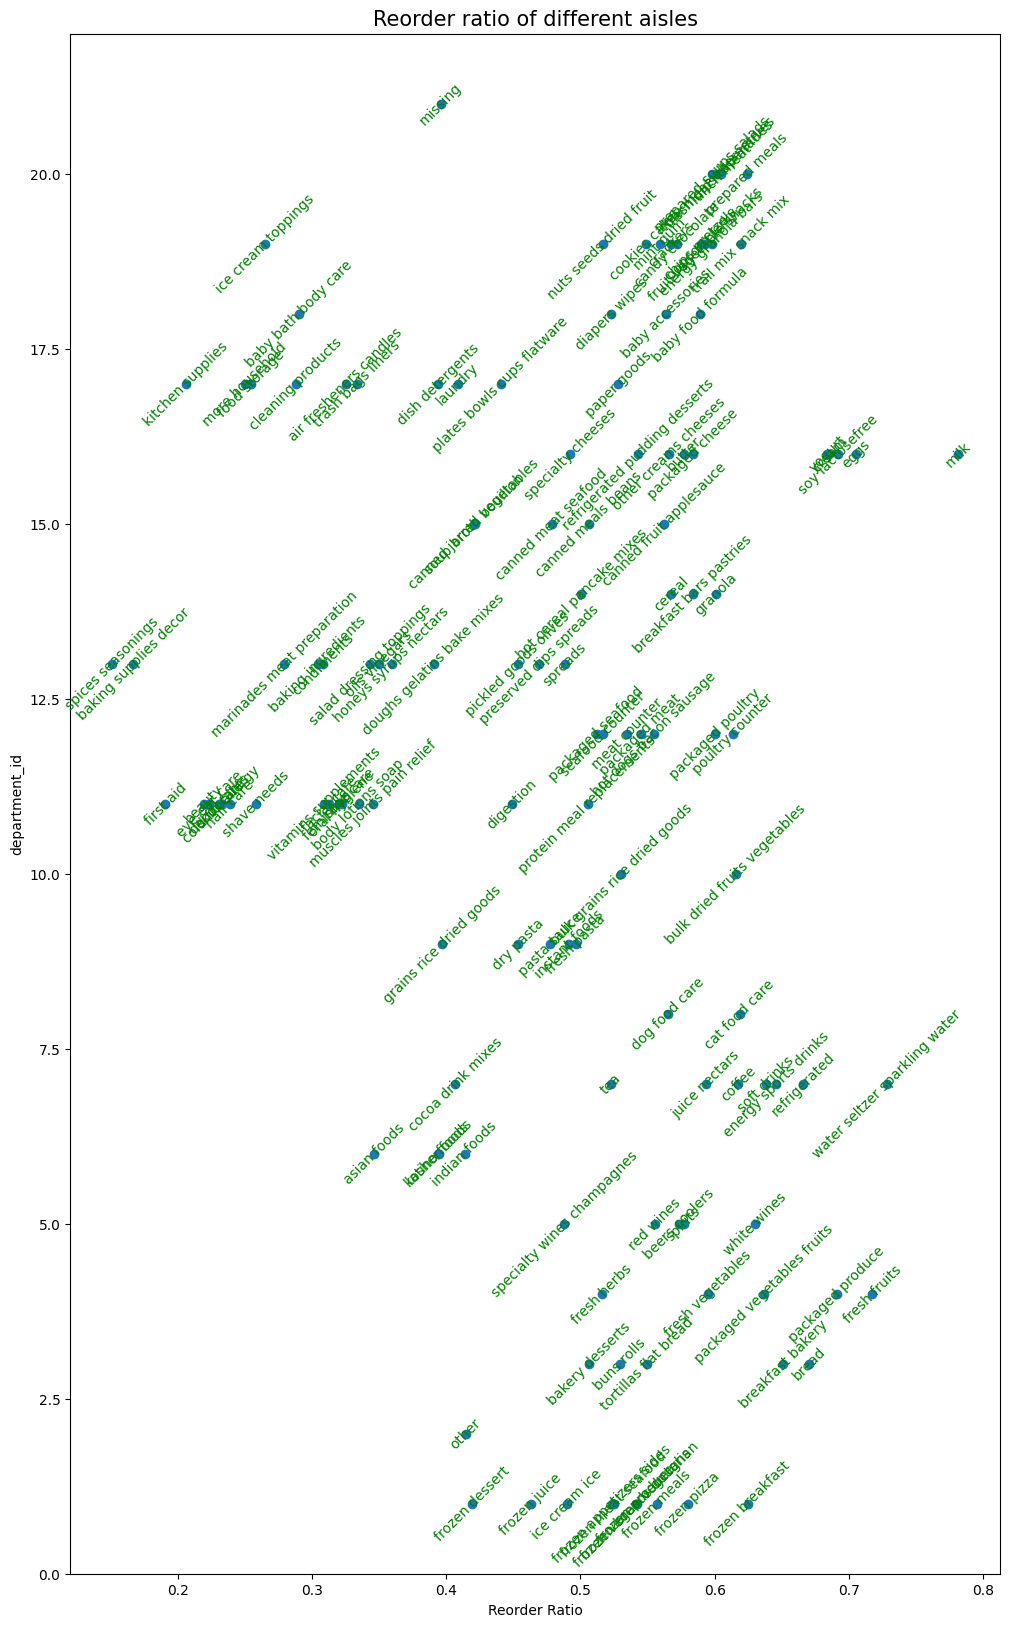

In [46]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

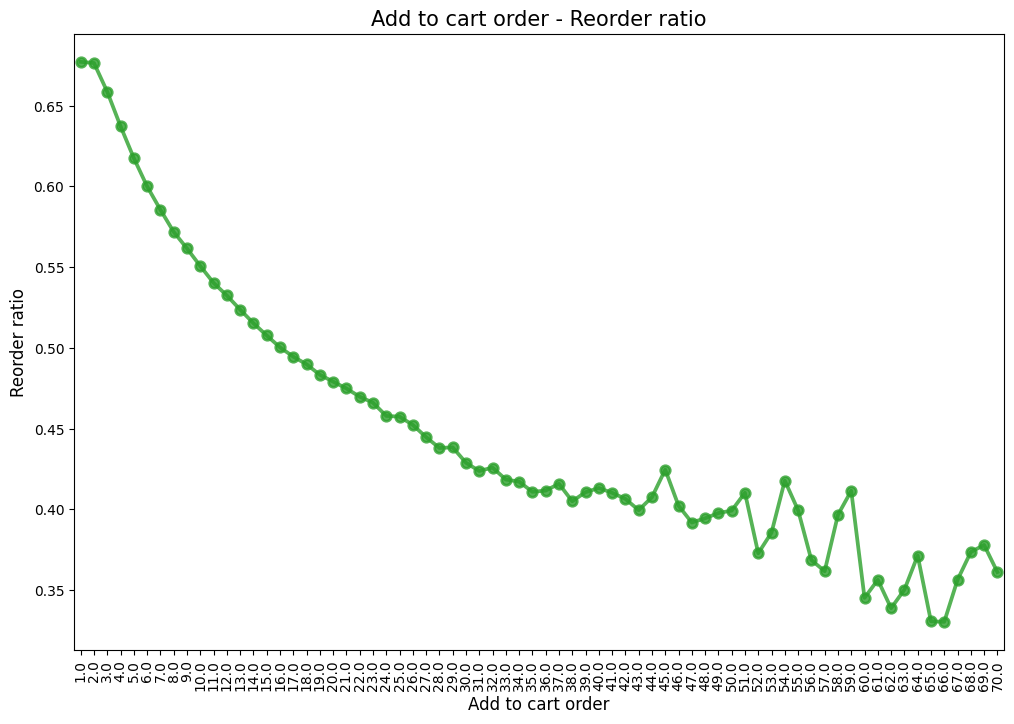

In [47]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df.loc[order_products_prior_df["add_to_cart_order_mod"]>70, "add_to_cart_order_mod"] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x = grouped_df['add_to_cart_order_mod'].values, y = grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [54]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

MergeError: Passing 'suffixes' which cause duplicate columns {'order_number_x', 'order_hour_of_day_x', 'user_id_x', 'days_since_prior_order_x', 'eval_set_x', 'order_dow_x'} is not allowed.

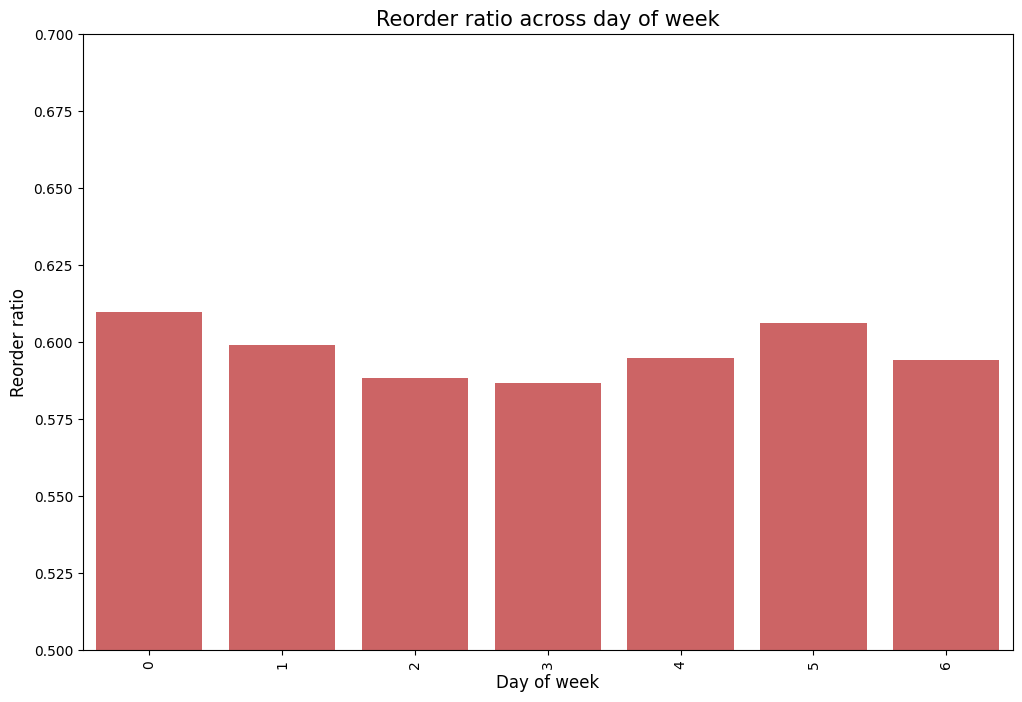

In [51]:
#오류 수정된 코드

order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id',
                                   how='left', suffixes=('_train', '_order'))
# orders_df와 order_dow 컬럼명이 중복돼서 suffixes로 컬럼명 구분되도록 수정
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.barplot(x = grouped_df['order_dow'].values, y = grouped_df['reordered'].values,
            alpha=0.8, color=color[3])
#x, y인자를 기재하여 명확히 구분되도록
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

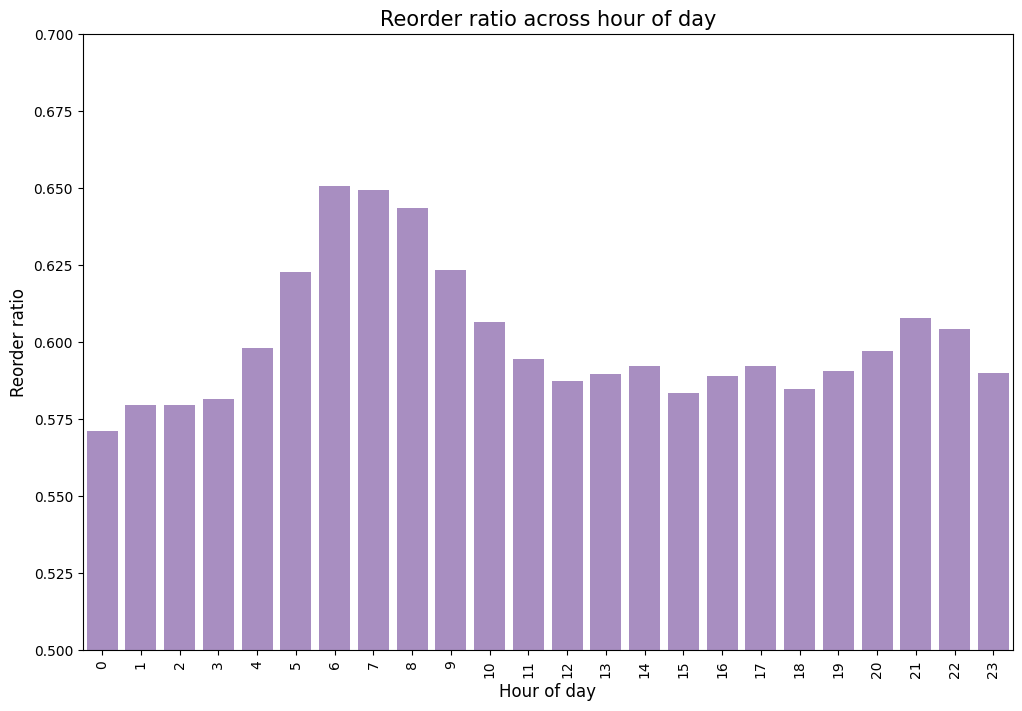

In [53]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x = grouped_df['order_hour_of_day'].values, y = grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

In [55]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

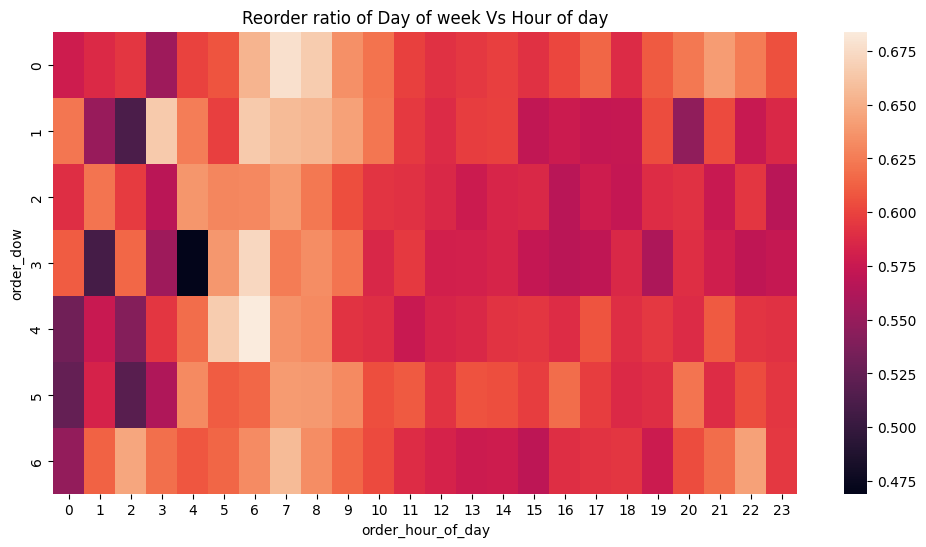

In [56]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot(index = 'order_dow', columns = 'order_hour_of_day', values = 'reordered')
# pivot 사용을 위해서는 index, columns, values 같은 키워드 인자 필요
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

박스플롯 시각화하면 좋을 듯